In [ ]:
"""
Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20
"""

In [2]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tqdm import tqdm

In [3]:
NUM_CLASSES = 10
NUM_FEATURES = 784

def load_dataset():
    mndata = MNIST('/Users/jmmar/Google Drive/School/ASU/Fall 2022/EEE 598/HW2/data/')
    mndata.gz = True  # allows the use of the .gz compressed files
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, y_train = map(tensor, mndata.load_training())
    X_test, y_test = map(tensor, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return X_train, y_train, X_test, y_test    

In [88]:
def plot_loss(train_losses, val_losses):
    iterations = list(range(len(train_losses)))
    plt.plot(iterations, train_losses, label='Train')
    plt.plot(iterations, val_losses, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.title('Loss While Training')
    plt.show()
    
def plot_acc(train_accs, val_accs):
    iterations = list(range(len(train_accs)))
    plt.plot(iterations, train_accs, label='Train')
    plt.plot(iterations, val_accs, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Accuracy While Training')
    plt.show()

In [82]:
class StandardLogisticRegressionModel(tf.Module):
    def __init__(self, num_classes, num_features, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.num_features = num_features
        self.w = tf.Variable(tf.zeros([num_features, num_classes]), name='weight')
        self.b = tf.Variable(tf.zeros([num_classes]), name='bias')
        
    def __call__(self, x):
        """Returns raw, unscaled logits for purposed of using the built-in loss function.
        
        """
        return tf.matmul(x, self.w) + self.b
    
    def predict(self, x):
        """Returns predicted class probabilities.
        """
        return tf.nn.softmax(self.__call__(x))
    
    def train(self, x, y, loss_func, learning_rate):
        with tf.GradientTape() as tape:
            current_loss = loss_func(y, self.__call__(x), self)
        # Update using gradient descent
        dl_dw, dl_db = tape.gradient(current_loss, [self.w, self.b])
        model.w.assign_sub(learning_rate * dl_dw)
        model.b.assign_sub(learning_rate * dl_db)
    
def ce_loss(y_true, y_pred, model):
    """ Takes one-hot-encoded class labels
    """
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred))

def ridge_ce_loss(y_true, y_pred, model, lam):
    regularizer_term = tf.reduce_sum(model.w ** 2)
    return ce_loss(y_true, y_pred, model) + lam * regularizer_term

def accuracy(y_pred, y_true):
    y_true_vals = tf.argmax(y_true, axis=1)
    y_pred_vals = tf.argmax(y_pred, axis=1)
    correct_preds = tf.equal(y_true_vals, y_pred_vals)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))



In [7]:
X_train, y_train, X_test, y_test = load_dataset()


In [73]:
def training_loop(model, X, y, num_epochs, loss, learning_rate):
    X_train, X_val, y_train, y_val = validation_split(X, y)
    y_train_one_hot = tf.one_hot(tf.cast(y_train, tf.int64), depth=NUM_CLASSES)
    y_val_one_hot = tf.one_hot(tf.cast(y_val, tf.int64), depth=NUM_CLASSES)
    weights = []
    biases = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in tqdm(range(num_epochs)):
        model.train(X_train, y_train_one_hot, loss_func=loss, learning_rate=0.1)
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        y_train_pred, y_val_pred = model(X_train), model(X_val)
        train_loss.append(loss(y_train_one_hot, y_train_pred, model))
        val_loss.append(loss(y_val_one_hot, y_val_pred, model))
        train_acc.append(accuracy(y_train_one_hot, tf.nn.softmax(y_train_pred)))
        val_acc.append(accuracy(y_val_one_hot, tf.nn.softmax(y_val_pred)))
    return weights, biases, train_loss, val_loss, train_acc, val_acc

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.52it/s]


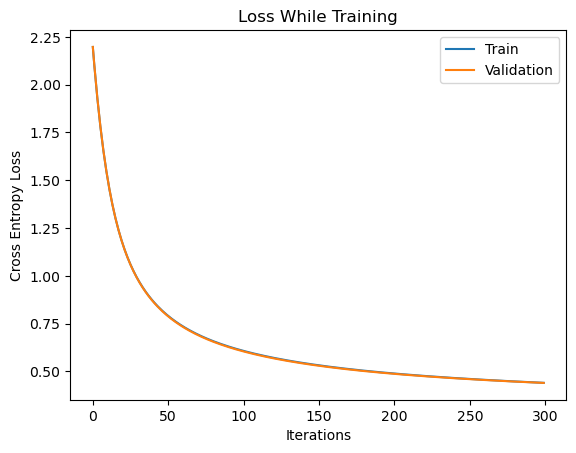

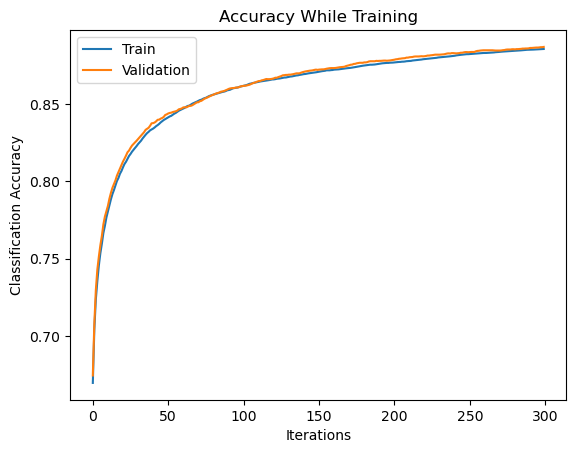

In [79]:
model = StandardLogisticRegressionModel(NUM_CLASSES, NUM_FEATURES)

weights, biases, train_loss, val_loss, train_acc, val_acc = training_loop(model, X_train, y_train, 300, ce_loss, .1)

plot_loss(train_loss, val_loss)
plot_acc(train_acc, val_acc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 18.97it/s]


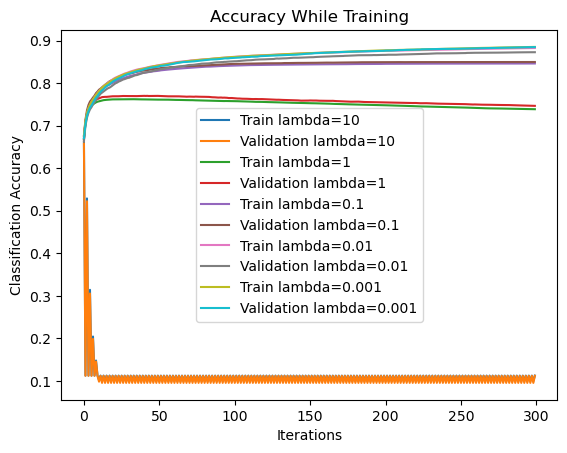

In [87]:
""" Experiment to see if ridge regression benefits accuracy. However, base model does not appear to overfit,
so I don't know that it is necessary.
"""

epochs = 300

for lam in [10, 1, .1, .01, .001]:
    model = StandardLogisticRegressionModel(NUM_CLASSES, NUM_FEATURES)
    loss = lambda *x: ridge_ce_loss(*x, lam)
    weights, biases, train_loss, val_loss, train_acc, val_acc = training_loop(model, X_train, y_train, epochs, loss, .1)
    plt.plot(list(range(epochs)), train_acc, label='Train lambda={}'.format(lam))
    plt.plot(list(range(epochs)), val_acc, label='Validation lambda={}'.format(lam))
plt.xlabel('Iterations')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.title('Accuracy While Training')
plt.show()


In [49]:
print(tf.reduce_max(model.w))

tf.Tensor(0.5046411, shape=(), dtype=float32)
